In [109]:
from game_of_life import Game_of_life
from autoencoder import ConvolutionalAutoencoder
from fullycon import CullyConnCoder

import torch.nn as nn
import torch
import tqdm
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

SIZE=64
SIM_BATHC = 6
ADVANCED_ENEI_PARAM = 0.001 # THE LAN REGULARIZATION PARAMETER

def generate_batch(batch_size, size, sims=SIM_BATHC, n_plus = 1):
    with torch.no_grad():
        game = Game_of_life(size)
        game.to(device)
        # random binary noise of size size x size
        prev_batch = torch.randint(0, 2, (batch_size, 1, size, size), device=device)
        batch = game(prev_batch)

        for i in range(sims):
            batch, prev_batch = game(batch), batch

        for i in range(1, n_plus):
            batch = game(batch)

        return prev_batch, batch


def cell_count_MSE(outputs, labels, input):
    # count of dead cells in the output
    alive_cells = torch.sum(outputs == 1, dim=(1,2,3)).float()
    dead_cells = torch.sum(outputs == 0, dim=(1,2,3)).float()

    # log_dead_cell s = torch.mean(torch.sigmoid(alive_cells + 1)) / (SIZE*SIZE)
    # step_diff = torch.mean(input - outputs) # ADVANCED_ENEI_PARAM
    lanoid_fraction = torch.mean(torch.abs(alive_cells - dead_cells)) / (SIZE*SIZE)

    mse_loss = nn.MSELoss()(outputs, labels)

    loss = torch.add(mse_loss, ADVANCED_ENEI_PARAM * lanoid_fraction )
    return loss

def train_model(epochs, lr):
    # Use the ResNet18 when implemented
    # net = ConvolutionalAutoencoder(SIZE)
    net = CullyConnCoder(SIZE)
    net.to(device)

    # Define the loss function
    # criterion = nn.BCELoss(reduction='mean') 
    # criterion = nn.MSELoss()
    criterion = cell_count_MSE

    # criterion = nn.CrossEntropyLoss()
    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    losses = []
    # loss_ra = 0
    for epoch in tqdm.tqdm(range(epochs)):
        # Get the inputs; Data is a tuple of (images, labels)
        inputs, labels = generate_batch(200, SIZE, SIM_BATHC, 1)

        # Clear the saved gradients of the previous iteration
        optimizer.zero_grad()

        outputs = net(inputs)
        # print(torch.min(outputs[0]), torch.max(outputs[0]))
        
        # # Calculate the loss value
        loss = criterion(outputs.float(), labels.float(), inputs.float())
        losses.append(loss.data.cpu().detach().numpy())

        # # Calculate the gradients using backpropagation
        loss.backward()
        # loss_ra += loss.data.cpu().detach().numpy()
        # # Update the weights of the network using the chosen optimizer
        optimizer.step()


        if (epoch % 100) == 0:
            # print(torch.sum(outputs[0] - labels[0]))
            print(loss.data.cpu().detach().numpy())
            # lr /= 1.1


    # net.eval()
    # test_bird_model(net,testloader)
    
    return net, losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import matplotlib.pyplot as plt
# torch.cuda.empty_cache()

net,losses = train_model(3000, 0.001)
# prosim delaj



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 21/5000 [00:00<00:48, 103.68it/s]

0.21529871


  2%|▏         | 119/5000 [00:00<00:37, 131.33it/s]

0.1289046


  4%|▍         | 219/5000 [00:01<00:34, 140.59it/s]

0.11861116


  6%|▋         | 319/5000 [00:02<00:34, 133.80it/s]

0.11276077


  8%|▊         | 418/5000 [00:03<00:33, 136.67it/s]

0.10671514


 10%|█         | 520/5000 [00:03<00:32, 136.77it/s]

0.09933466


 12%|█▏        | 618/5000 [00:04<00:32, 135.20it/s]

0.09005665


 14%|█▍        | 721/5000 [00:05<00:30, 140.09it/s]

0.085629925


 16%|█▋        | 822/5000 [00:06<00:30, 136.49it/s]

0.08070508


 18%|█▊        | 925/5000 [00:06<00:29, 137.17it/s]

0.07852036


 21%|██        | 1028/5000 [00:07<00:28, 141.36it/s]

0.076721184


 23%|██▎       | 1127/5000 [00:08<00:28, 135.81it/s]

0.07623006


 25%|██▍       | 1228/5000 [00:09<00:27, 139.43it/s]

0.075595714


 26%|██▋       | 1315/5000 [00:09<00:26, 141.21it/s]

0.07478779


 28%|██▊       | 1418/5000 [00:10<00:25, 141.53it/s]

0.074529536


 30%|███       | 1519/5000 [00:11<00:24, 139.49it/s]

0.074653566


 32%|███▏      | 1624/5000 [00:11<00:24, 138.48it/s]

0.07396358


 34%|███▍      | 1723/5000 [00:12<00:24, 134.84it/s]

0.07428956


 36%|███▋      | 1823/5000 [00:13<00:23, 135.36it/s]

0.0735809


 39%|███▊      | 1926/5000 [00:14<00:21, 140.19it/s]

0.07386939


 40%|████      | 2015/5000 [00:14<00:21, 139.10it/s]

0.073145114


 42%|████▏     | 2115/5000 [00:15<00:21, 136.82it/s]

0.0729083


 44%|████▍     | 2215/5000 [00:16<00:20, 137.86it/s]

0.071347505


 47%|████▋     | 2329/5000 [00:17<00:19, 138.90it/s]

0.072445974


 48%|████▊     | 2416/5000 [00:17<00:18, 138.71it/s]

0.071692705


 50%|█████     | 2519/5000 [00:18<00:17, 140.84it/s]

0.07164895


 52%|█████▏    | 2624/5000 [00:19<00:16, 140.67it/s]

0.070696086


 55%|█████▍    | 2729/5000 [00:19<00:15, 143.16it/s]

0.07087875


 56%|█████▋    | 2818/5000 [00:20<00:15, 141.76it/s]

0.07051399


 58%|█████▊    | 2923/5000 [00:21<00:14, 140.01it/s]

0.07086876


 61%|██████    | 3026/5000 [00:22<00:14, 139.67it/s]

0.07027331


 63%|██████▎   | 3129/5000 [00:22<00:13, 139.82it/s]

0.07059587


 65%|██████▍   | 3228/5000 [00:23<00:12, 138.97it/s]

0.06946426


 67%|██████▋   | 3328/5000 [00:24<00:12, 138.60it/s]

0.07026425


 69%|██████▊   | 3426/5000 [00:24<00:11, 134.03it/s]

0.06985974


 71%|███████   | 3526/5000 [00:25<00:10, 139.58it/s]

0.069719195


 73%|███████▎  | 3626/5000 [00:26<00:09, 138.29it/s]

0.06946241


 74%|███████▍  | 3715/5000 [00:27<00:09, 139.55it/s]

0.0686672


 76%|███████▋  | 3820/5000 [00:27<00:08, 143.53it/s]

0.068215914


 78%|███████▊  | 3925/5000 [00:28<00:07, 141.15it/s]

0.06789514


 81%|████████  | 4030/5000 [00:29<00:06, 143.52it/s]

0.06870341


 82%|████████▏ | 4120/5000 [00:29<00:06, 142.21it/s]

0.0677191


 84%|████████▍ | 4225/5000 [00:30<00:05, 143.34it/s]

0.06861484


 87%|████████▋ | 4328/5000 [00:31<00:04, 136.56it/s]

0.06787377


 89%|████████▊ | 4428/5000 [00:32<00:04, 136.23it/s]

0.06750382


 91%|█████████ | 4526/5000 [00:32<00:03, 134.56it/s]

0.06789204


 92%|█████████▎| 4625/5000 [00:33<00:02, 136.75it/s]

0.0663979


 94%|█████████▍| 4724/5000 [00:34<00:02, 137.68it/s]

0.06775799


 96%|█████████▋| 4824/5000 [00:35<00:01, 137.06it/s]

0.066933714


 98%|█████████▊| 4923/5000 [00:35<00:00, 134.85it/s]

0.06616642


100%|██████████| 5000/5000 [00:36<00:00, 137.68it/s]


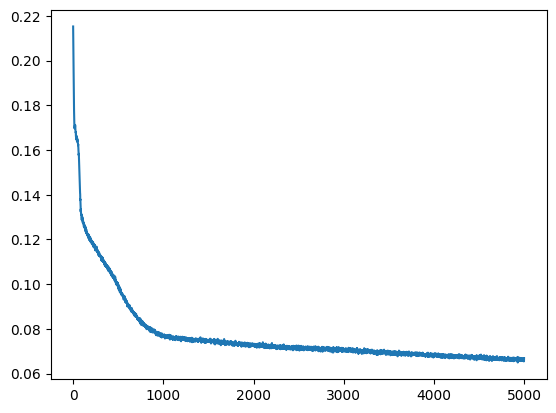

In [111]:
plt.plot(losses)
plt.show()

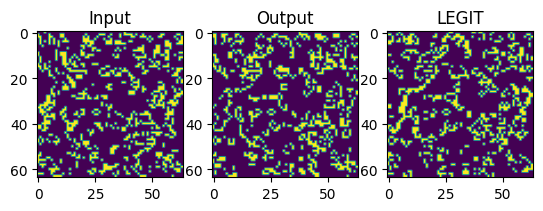

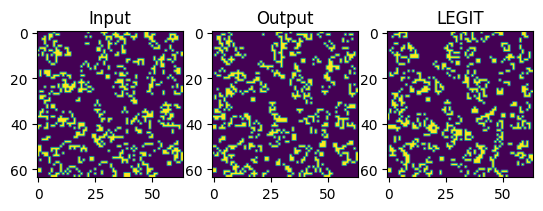

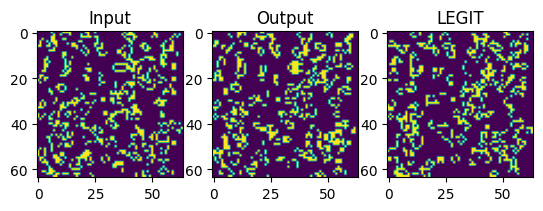

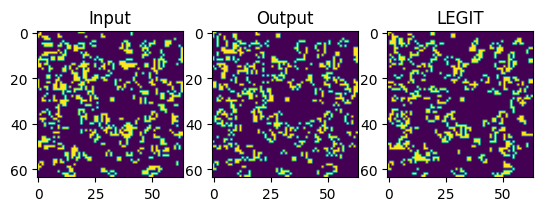

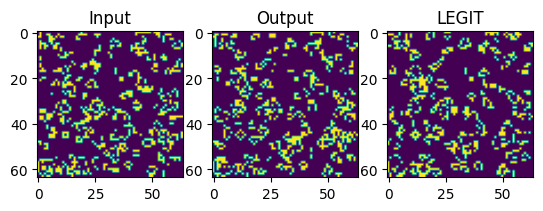

In [82]:
#RANDOM TRIES
batch, next= generate_batch(5, SIZE, SIM_BATHC, 2)
out = net(batch).cpu().detach().numpy()
out = out > 0.5
ba = batch.cpu().detach().numpy()
ne = next.cpu().detach().numpy()

for i in range(5):
    ins = ba[i][0]
    res = out[i][0]
    nes = ne[i][0]
    fix, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(ins)
    ax1.set_title("Input")
    ax2.imshow(res)
    ax2.set_title("Output")
    ax3.imshow(nes)
    ax3.set_title("LEGIT")


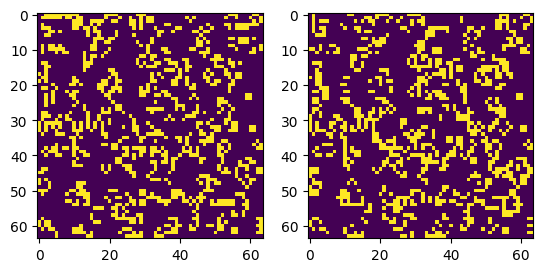

In [15]:
L = 1
out = generate_batch(L, SIZE, SIM_BATHC, 1)
for i in range(L):
    ins = out[0][i][0].cpu().detach().numpy()
    res = out[1][i][0].cpu().detach().numpy()
    fix, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ins)
    ax2.imshow(res)

In [119]:
import pygame
SIZE = 128
GAME_SIZE = 8

def get_new(previous:torch.Tensor, net:torch.nn.Module):
    with torch.no_grad():
        tensor = net(previous)
        return tensor, tensor.squeeze().cpu().detach().numpy() > 0.5

def display_grid(grid, screen):
    size = len(grid)
    cell_size = GAME_SIZE
    for i in range(size):
        for j in range(size):
            if grid[i][j] == 1:
                pygame.draw.rect(screen, (255, 255, 255), (i*cell_size, j*cell_size, cell_size, cell_size))
            else:
                pygame.draw.rect(screen, (0, 0, 0), (i*cell_size, j*cell_size, cell_size, cell_size))
    pygame.display.flip()

first, second = generate_batch(1, SIZE, 15, 1)
tensor, grid = get_new(first, net)
pygame.init()
screen = pygame.display.set_mode((SIZE*GAME_SIZE, SIZE*GAME_SIZE))

running = True
i = 0
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_SPACE:
                running = False
        # r resetes game with new random grid
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_r:
                first, second = generate_batch(1, SIZE, 15, 1)
                tensor, grid = get_new(first, net)
        # plt.imshow(grid) and save it when S is pressed
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_s:
                plt.imshow(grid, cmap='gray')
                plt.savefig(f"grid_{i}.png")
    tensor, grid = get_new(tensor, net)
    display_grid(grid, screen)
    pygame.time.wait(100)
    # if(tensor.sum() == 0 or tensor.sum() == SIZE*SIZE):
    #     running = False
    i += 1

pygame.quit()

In [67]:
pygame.quit()